In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/blood-dataset/images/TEST_SIMPLE/MONOCYTE/_2_4392.jpeg
/kaggle/input/blood-dataset/images/TEST_SIMPLE/MONOCYTE/_1_4511.jpeg
/kaggle/input/blood-dataset/images/TEST_SIMPLE/MONOCYTE/_0_5020.jpeg
/kaggle/input/blood-dataset/images/TEST_SIMPLE/MONOCYTE/_3_9457.jpeg
/kaggle/input/blood-dataset/images/TEST_SIMPLE/NEUTROPHIL/_1_2118.jpeg
/kaggle/input/blood-dataset/images/TEST_SIMPLE/NEUTROPHIL/_45_5733.jpeg
/kaggle/input/blood-dataset/images/TEST_SIMPLE/NEUTROPHIL/_7_8956.jpeg
/kaggle/input/blood-dataset/images/TEST_SIMPLE/NEUTROPHIL/_18_4469.jpeg
/kaggle/input/blood-dataset/images/TEST_SIMPLE/NEUTROPHIL/_41_2530.jpeg
/kaggle/input/blood-dataset/images/TEST_SIMPLE/NEUTROPHIL/_6_2289.jpeg
/kaggle/input/blood-dataset/images/TEST_SIMPLE/NEUTROPHIL/_10_170.jpeg
/kaggle/input/blood-dataset/images/TEST_SIMPLE/NEUTROPHIL/_47_8207.jpeg
/kaggle/input/blood-dataset/images/TEST_SIMPLE/NEUTROPHIL/_12_4753.jpeg
/kaggle/input/blood-dataset/images/TEST_SIMPLE/NEUTROPHIL/_34_3330.jpeg
/kaggle/

In [2]:
import torch.nn as nn
import torch


class BasicBlock(nn.Module):
    expansion = 1  #一个block中主分支卷积核有没有发生变化，此处不变

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        # downsample = None 对应残差结构中的虚线，有降维的作用，此处不降维
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    """
    注意：原论文中，在虚线残差结构的主分支上，第一个1x1卷积层的步距是2，第二个3x3卷积层步距是1。
    但在pytorch官方实现过程中是第一个1x1卷积层的步距是1，第二个3x3卷积层步距是2，
    这么做的好处是能够在top1上提升大概0.5%的准确率。
    可参考Resnet v1.5 https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch
    """
    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None,
                 groups=1, width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channel*self.expansion,
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 blocks_num,
                 num_classes=1000,
                 include_top=True,
                 groups=1,
                 width_per_group=64):
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.groups = groups
        self.width_per_group = width_per_group

        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel,
                            channel,
                            downsample=downsample,
                            stride=stride,
                            groups=self.groups,
                            width_per_group=self.width_per_group))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel,
                                channel,
                                groups=self.groups,
                                width_per_group=self.width_per_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x


def resnet34(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet34-333f7ec4.pth
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet50(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet50-19c8e357.pth
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)


def resnext50_32x4d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth
    groups = 32
    width_per_group = 4
    return ResNet(Bottleneck, [3, 4, 6, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


def resnext101_32x8d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth
    groups = 32
    width_per_group = 8
    return ResNet(Bottleneck, [3, 4, 23, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)

In [3]:
!pip install torchinfo

using cuda:0 device.
using 9957 images for training, 2487 images for validation.
valid epoch[1/50]: 100%|██████████| 156/156 [00:24<00:00,  6.24it/s]
[epoch 1] train_loss: 1.282  val_accuracy: 0.60676
valid epoch[2/50]: 100%|██████████| 156/156 [00:15<00:00, 10.35it/s]
[epoch 2] train_loss: 0.940  val_accuracy: 0.67913
valid epoch[3/50]: 100%|██████████| 156/156 [00:18<00:00,  8.21it/s]
[epoch 3] train_loss: 0.735  val_accuracy: 0.78850
valid epoch[4/50]: 100%|██████████| 156/156 [00:15<00:00,  9.99it/s]
[epoch 4] train_loss: 0.624  val_accuracy: 0.82791
valid epoch[5/50]: 100%|██████████| 156/156 [00:15<00:00,  9.83it/s]
[epoch 5] train_loss: 0.578  val_accuracy: 0.80820
valid epoch[6/50]: 100%|██████████| 156/156 [00:15<00:00, 10.37it/s]
[epoch 6] train_loss: 0.500  val_accuracy: 0.83072
valid epoch[7/50]: 100%|██████████| 156/156 [00:15<00:00, 10.01it/s]
[epoch 7] train_loss: 0.472  val_accuracy: 0.85565
valid epoch[8/50]: 100%|██████████| 156/156 [00:16<00:00,  9.54it/s]
[epoch 8] 

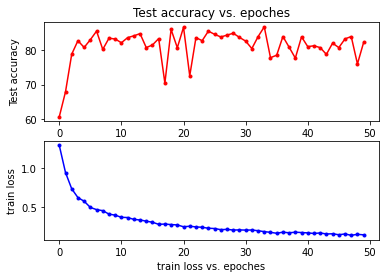

finished print


<Figure size 432x288 with 0 Axes>

In [4]:
import os
import sys
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm import tqdm

import matplotlib.pyplot as plt
from torchinfo import summary
    
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))
    
    Loss_list = []
    Accuracy_list = []
    batch_size = 16
    epochs = 50

    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        "val": transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

#     data_root = os.path.abspath(os.path.join(os.getcwd(), "../"))  # get data root path
#     image_path = os.path.join(data_root, "blood_cell", "dataset2-master","dataset2-master"
#                               ,"images")  # flower data set path
#     assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    train_dataset = datasets.ImageFolder(root="../input/blood-dataset/images/TRAIN",
                                         transform=data_transform["train"])
    train_num = len(train_dataset)

    # {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
    # flower_list = train_dataset.class_to_idx
    # cla_dict = dict((val, key) for key, val in flower_list.items())
    # # write dict into json file
    # json_str = json.dumps(cla_dict, indent=4)
    # with open('class_indices.json', 'w') as json_file:
    #     json_file.write(json_str)

    #nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    #print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=0)

    validate_dataset = datasets.ImageFolder(root="../input/blood-dataset/images/TEST",
                                            transform=data_transform["val"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=0)

    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))

    # create model
    net = resnet50(num_classes=4)

    # load pretrain weights
    # download url: https://download.pytorch.org/models/mobilenet_v2-b0353104.pth
#     model_weight_path = "./resnet34.pth"
#     assert os.path.exists(model_weight_path), "file {} dose not exist.".format(model_weight_path)
#     pre_weights = torch.load(model_weight_path, map_location='cpu')

#     # delete classifier weights
#     pre_dict = {k: v for k, v in pre_weights.items() if net.state_dict()[k].numel() == v.numel()}
#     missing_keys, unexpected_keys = net.load_state_dict(pre_dict, strict=False)

    # freeze features weights
    # for param in net.features.parameters():
    #     param.requires_grad = False

    net.to(device)

    # define loss function
    loss_function = nn.CrossEntropyLoss()

    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr=0.00003)#0.0001

    save_path = './resnet50.pth'
    train_steps = len(train_loader)
    for epoch in range(epochs):
        # train
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, file=sys.stdout)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            logits = net(images.to(device))
            loss = loss_function(logits, labels.to(device))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)

        # validate
        net.eval()
        best_acc=0.0
        acc = 0.0  # accumulate accurate number / epoch
        with torch.no_grad():
            val_bar = tqdm(validate_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                # loss = loss_function(outputs, test_labels)
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

                val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1,
                                                           epochs)
        val_accurate = acc / val_num
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.5f' %
              (epoch + 1, running_loss / train_steps, val_accurate))
        
        Loss_list.append(running_loss / train_steps)
        Accuracy_list.append(100 * val_accurate)

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)
            
        

    print('Finished Training')
    
    x1 = range(0, 50)
    x2 = range(0, 50)

    y1 = Accuracy_list
    y2 = Loss_list

    plt.subplot(2, 1, 1)
    plt.plot(x1, y1, '.-',color = 'r')
    plt.title('Test accuracy vs. epoches')
    plt.ylabel('Test accuracy')
    plt.subplot(2, 1, 2)
    plt.plot(x2, y2, '.-',color = 'b')
    plt.xlabel('train loss vs. epoches')
    plt.ylabel('train loss')
    plt.show()
    plt.savefig("accuracy_loss.jpg")


    print("finished print")

if __name__ == '__main__':
    main()

In [5]:
net = resnet50(num_classes=4)
from torchinfo import summary
summary(net, input_size=(16, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 4]                   --
├─Conv2d: 1-1                            [16, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [16, 64, 112, 112]        128
├─ReLU: 1-3                              [16, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [16, 64, 56, 56]          --
├─Sequential: 1-5                        [16, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [16, 256, 56, 56]         --
│    │    └─Sequential: 3-1              [16, 256, 56, 56]         16,896
│    │    └─Conv2d: 3-2                  [16, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-3             [16, 64, 56, 56]          128
│    │    └─ReLU: 3-4                    [16, 64, 56, 56]          --
│    │    └─Conv2d: 3-5                  [16, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-6             [16, 64, 56, 56]          12